# Load Dataset and Libraries

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import scipy.stats as ss
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,RocCurveDisplay, classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model 
from IPython.display import display
import warnings
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [56]:
df = pd.read_csv('./data/Guns incident Data.csv')
df.head()

,S.No.,Year,Month,Date,Reason,Education,Sex,Age,Race,Hispanic,Place of incident,Police involvement
0,1,2017,1,06-01-2017,Suicide,Bachelors,Male,35.0,Asian/Pacific Islander,100,Home,0
1,2,2017,1,19-01-2017,Suicide,Some college,Female,22.0,White,100,Street,0
2,3,2017,1,01-01-2017,Suicide,Bachelors,Male,61.0,White,100,Other specified,0
3,4,2017,2,06-02-2017,Suicide,Bachelors,Male,65.0,White,100,Home,0
4,5,2017,2,09-02-2017,Suicide,High School,Male,32.0,White,100,Other specified,0


# Data Cleaning

In [57]:
'''Drop columns S.No., Date, Hispanic; insert Reason as the first column.'''
df_clean = df.drop(['S.No.', 'Date', 'Hispanic'], axis=1)
df_clean.insert(0, 'Reason', df_clean.pop('Reason'))
df_clean.head()

,Reason,Year,Month,Education,Sex,Age,Race,Place of incident,Police involvement
0,Suicide,2017,1,Bachelors,Male,35.0,Asian/Pacific Islander,Home,0
1,Suicide,2017,1,Some college,Female,22.0,White,Street,0
2,Suicide,2017,1,Bachelors,Male,61.0,White,Other specified,0
3,Suicide,2017,2,Bachelors,Male,65.0,White,Home,0
4,Suicide,2017,2,High School,Male,32.0,White,Other specified,0


# Exploratory Data Analysis

In [58]:
''' Check percentage of missing values in each variable '''

na_percentage = df_clean.isna().sum() / df.shape[0] * 100

na_percentage = na_percentage.round(2)
print("Percentage of NaN values for each variable:")
print(na_percentage)

Percentage of NaN values for each variable:
Reason                0.00
Year                  0.00
Month                 0.00
Education             1.41
Sex                   0.00
Age                   0.02
Race                  0.00
Place of incident     1.37
Police involvement    0.00
dtype: float64


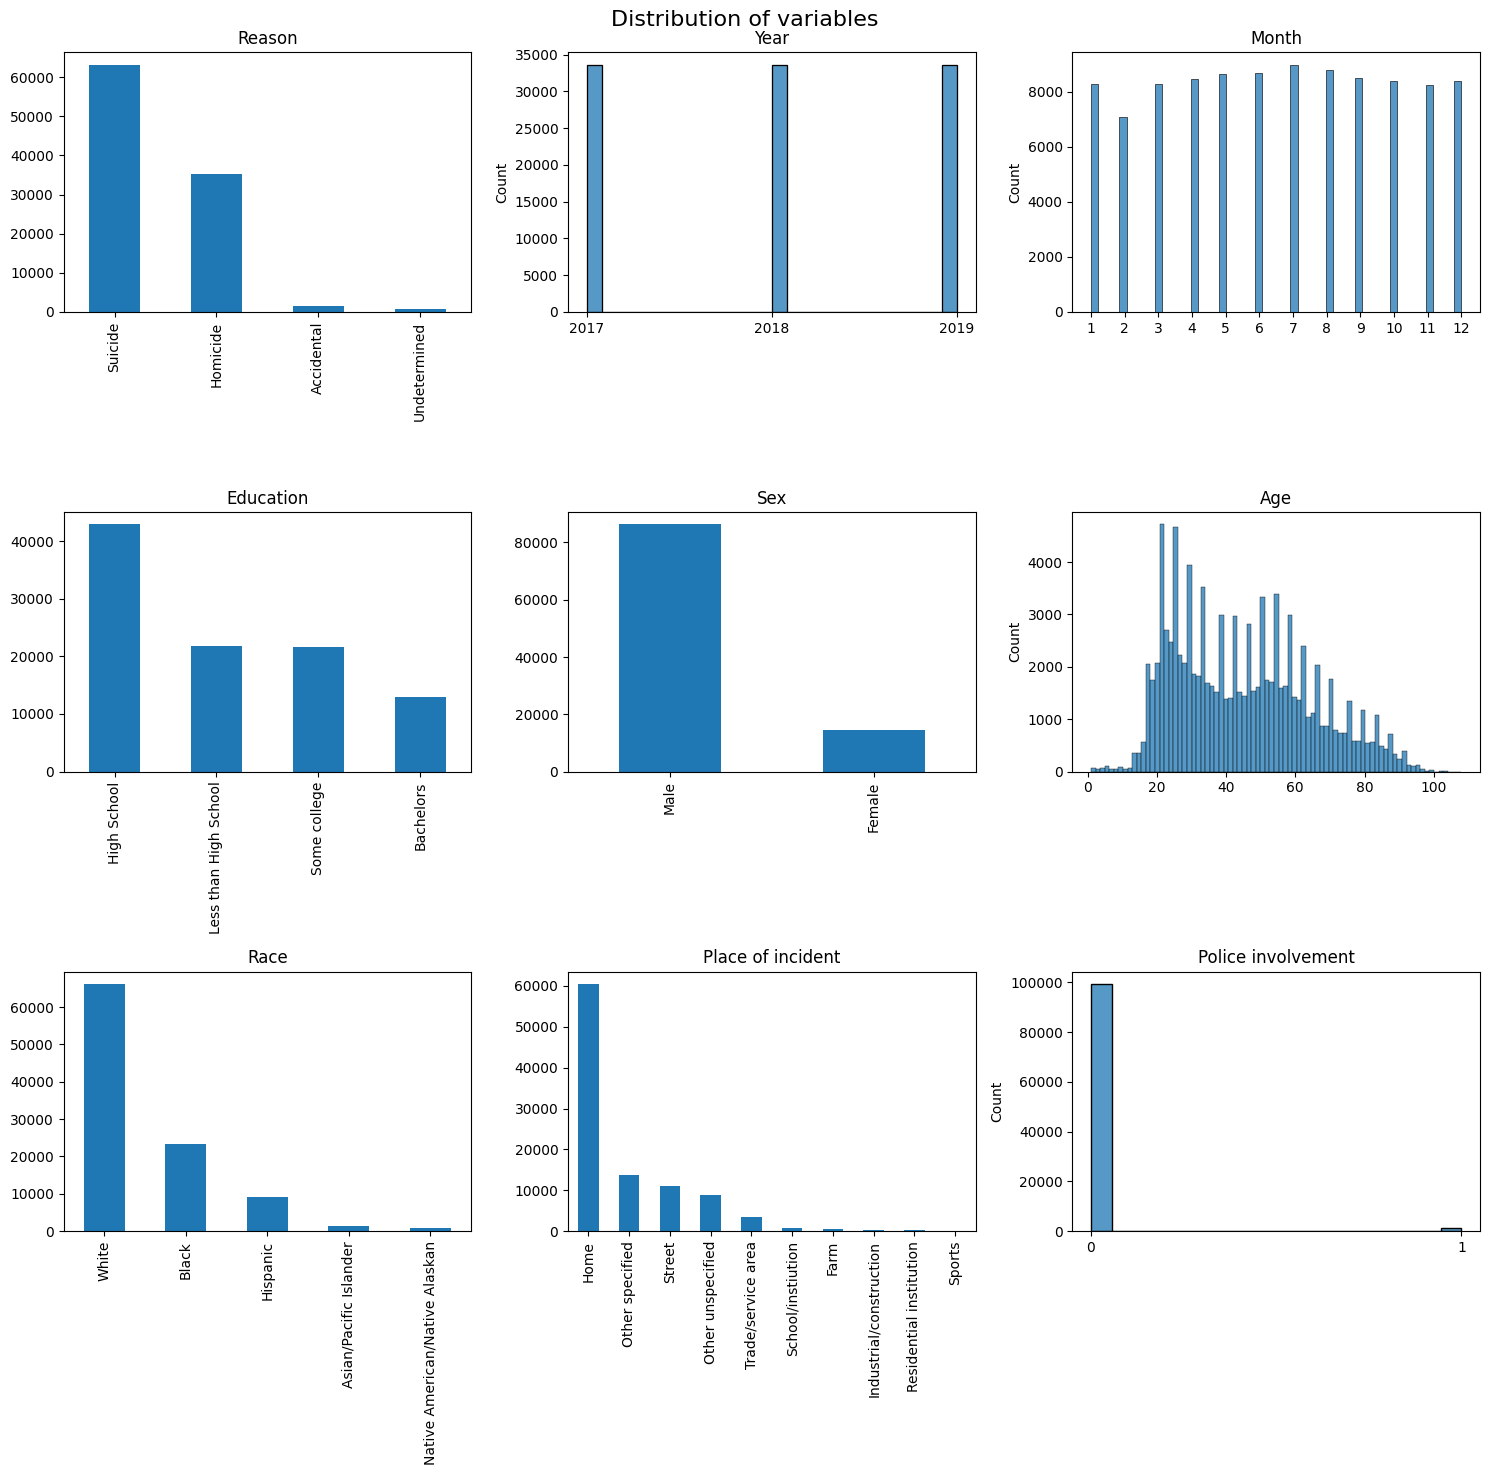

In [59]:
'''Plot distribution of all variables'''

discrete_numerical_var = ['Year','Month','Police involvement']
continuous_numerical_var = ['Age']
categorical_var = ['Education','Sex','Race','Place of incident','Reason']

#plt.style.use('seaborn')
fig,axs = plt.subplots(3,3, figsize=(15,15))
fig.suptitle('Distribution of variables', fontsize = 16)
idx = 0

for i in range(3):
  for j in range(3):
    var = df_clean.columns[idx]
    if var in discrete_numerical_var:
      sns.histplot(data = df, x = var, ax=axs[i,j])
      axs[i, j].set_xticks(range(min(df[var]),max(df[var])+1,1))
    elif var in continuous_numerical_var:
      sns.histplot(data = df, x = var, ax=axs[i,j])
    else:
      df[var].value_counts().plot(kind='bar', ax=axs[i,j])
    axs[i,j].set_xlabel('')
    axs[i,j].set_title(var)
    idx += 1

plt.tight_layout()

# Data Pre-processing

## Split into Train and Test Data

In [60]:
''' 80-20 ratio used, 80% data used for training, 20% used for testing '''
df_clean_train, df_clean_test = train_test_split(df_clean, test_size=0.2, random_state=42)

## Data Manipulation for Train Data

### Dealing with Missing Data

In [61]:
'''Check number of rows and columns with missing data'''
rows_with_missing = df_clean_train[df_clean_train.isnull().any(axis=1)]
print(rows_with_missing.shape)
columns_with_missing = df_clean_train.columns[df_clean_train.isnull().any()]
print(columns_with_missing)

(2222, 9)
Index(['Education', 'Age', 'Place of incident'], dtype='object')


#### Remove Missing Data from Train Data

In [62]:
df_clean_train_rem = df_clean_train.dropna()

#### Impute Missing Data from Train Data

In [63]:
# Impute ALL Missing Values
df_clean_train_imp = df_clean_train.copy()

# Age
age_imputer = SimpleImputer(strategy='median')
df_clean_train_imp['Age'] = age_imputer.fit_transform(df_clean_train_imp[['Age']])

# Education
education_counts = df_clean_train_imp['Education'].value_counts(normalize=True)
education_categories = education_counts.index.tolist()
education_probs = education_counts.values

np.random.seed(1)

df_clean_train_imp['Education'] = df_clean_train_imp['Education'].apply(
    lambda x: np.random.choice(education_categories, p = education_probs) if pd.isnull(x) else x
)

# Place of incident
place_counts = df_clean_train_imp['Place of incident'].value_counts(normalize=True)
place_categories = place_counts.index.tolist()
place_probs = place_counts.values

np.random.seed(1)

df_clean_train_imp['Place of incident'] = df_clean_train_imp['Place of incident'].apply(
    lambda x: np.random.choice(place_categories, p=place_probs) if pd.isnull(x) else x
)

### Encoding

#### Encode train data where missing values are **removed** ###

In [64]:
cleanup_nums = {"Education":     {"Less than High School": 0, "High School": 1,"Some college":2,"Bachelors":3}}       
df_clean_train_rem = df_clean_train_rem.replace(cleanup_nums)

#one hot encoding for gender
gender_ohe=pd.get_dummies(df_clean_train_rem.Sex) #gender one hot encoding
dftemp=df_clean_train_rem
dftemp=dftemp.drop(columns=["Sex"])
dftemp=pd.concat([gender_ohe,dftemp],axis=1)

#one hot encoding for race
race_ohe=pd.get_dummies(df_clean_train_rem.Race) #race one hot encoding
dftemp=dftemp.drop(columns=["Race"])
dftemp=pd.concat([race_ohe,dftemp],axis=1)

#one hot encoding for place of incident
place_ohe=pd.get_dummies(df_clean_train_rem["Place of incident"]) #place one hot encoding
dftemp=dftemp.drop(columns=["Place of incident"])
dftemp= pd.concat([place_ohe,dftemp],axis=1)

df_clean_train_remecd = dftemp


#### Encode train data where missing values are **imputed** ###

In [65]:
df_clean_train_imp = df_clean_train_imp.replace(cleanup_nums)

#one hot encoding for gender
gender_ohe=pd.get_dummies(df_clean_train_imp.Sex) #gender one hot encoding
dftemp=df_clean_train_imp
dftemp=dftemp.drop(columns=["Sex"])
dftemp=pd.concat([gender_ohe,dftemp],axis=1)

#one hot encoding for race
race_ohe=pd.get_dummies(df_clean_train_imp.Race) #race one hot encoding
dftemp=dftemp.drop(columns=["Race"])
dftemp=pd.concat([race_ohe,dftemp],axis=1)

#one hot encoding for place of incident
place_ohe=pd.get_dummies(df_clean_train_imp["Place of incident"]) #place one hot encoding
dftemp=dftemp.drop(columns=["Place of incident"])
dftemp= pd.concat([place_ohe,dftemp],axis=1)

df_clean_train_impecd = dftemp
df_train_final_imb = dftemp

### Resampling Under-represented Classes

#### Resample train data where missing values are **removed**

In [66]:
#df_clean_train_remecd['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined with majority class suicide having 49818 rows '''

majority_class_suicide = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Suicide']
minority_class_homicide = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Homicide']
minority_class_accidental = df_clean_train_remecd[df_clean_train_remecd['Reason']=='Accidental']
minority_class_undetermined= df_clean_train_remecd[df_clean_train_remecd['Reason']=='Undetermined']

df_cr_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=4) #df_cleanremove_...
df_cr_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=4)
df_cr_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=4)

df_train_final_rem= pd.concat([majority_class_suicide,df_cr_oversamp_hom,df_cr_oversamp_acc, df_cr_oversamp_und])
df_train_final_rem.head()

,Farm,Home,Industrial/construction,Other specified,Other unspecified,Residential institution,School/instiution,Sports,Street,Trade/service area,...,Native American/Native Alaskan,White,Female,Male,Reason,Year,Month,Education,Age,Police involvement
93874,False,True,False,False,False,False,False,False,False,False,...,False,True,True,False,Suicide,2019,2,2,69.0,0
8119,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,8,0,77.0,0
3211,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,4,1,46.0,0
65943,False,False,False,True,False,False,False,False,False,False,...,False,True,False,True,Suicide,2018,11,3,60.0,0
29973,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,Suicide,2017,11,0,31.0,0


#### Resample train data where missing values are **imputed**

In [67]:
#df_clean_train_impecd['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined
with majority class suicide having 50580 rows '''

majority_class_suicide = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Suicide']
minority_class_homicide = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Homicide']
minority_class_accidental = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Accidental']
minority_class_undetermined= df_clean_train_impecd[df_clean_train_impecd['Reason']=='Undetermined']

df_ci_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=42)

df_train_final_imp= pd.concat([majority_class_suicide,df_ci_oversamp_hom,df_ci_oversamp_acc, df_ci_oversamp_und])
df_train_final_imp.head()

,Farm,Home,Industrial/construction,Other specified,Other unspecified,Residential institution,School/instiution,Sports,Street,Trade/service area,...,Native American/Native Alaskan,White,Female,Male,Reason,Year,Month,Education,Age,Police involvement
93874,False,True,False,False,False,False,False,False,False,False,...,False,True,True,False,Suicide,2019,2,2,69.0,0
8119,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,8,0,77.0,0
3211,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,4,1,46.0,0
65943,False,False,False,True,False,False,False,False,False,False,...,False,True,False,True,Suicide,2018,11,3,60.0,0
29973,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,Suicide,2017,11,0,31.0,0


#### Resample train data where missing values are **imputed**

In [68]:
#df_clean_train_impecd['Reason'].value_counts(), majority class for imputed training data is suicide 
mclass_len = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Suicide'].shape[0]
'''underrepresented classes are homicide, accidental, undetermined
with majority class suicide having 50580 rows '''

majority_class_suicide = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Suicide']
minority_class_homicide = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Homicide']
minority_class_accidental = df_clean_train_impecd[df_clean_train_impecd['Reason']=='Accidental']
minority_class_undetermined= df_clean_train_impecd[df_clean_train_impecd['Reason']=='Undetermined']

df_ci_oversamp_hom = resample(minority_class_homicide, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_acc = resample(minority_class_accidental, replace=True, n_samples = mclass_len, random_state=42)
df_ci_oversamp_und = resample(minority_class_undetermined, replace=True, n_samples = mclass_len, random_state=42)

df_train_final_imp= pd.concat([majority_class_suicide,df_ci_oversamp_hom,df_ci_oversamp_acc, df_ci_oversamp_und])
df_train_final_imp.head()

,Farm,Home,Industrial/construction,Other specified,Other unspecified,Residential institution,School/instiution,Sports,Street,Trade/service area,...,Native American/Native Alaskan,White,Female,Male,Reason,Year,Month,Education,Age,Police involvement
93874,False,True,False,False,False,False,False,False,False,False,...,False,True,True,False,Suicide,2019,2,2,69.0,0
8119,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,8,0,77.0,0
3211,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,Suicide,2017,4,1,46.0,0
65943,False,False,False,True,False,False,False,False,False,False,...,False,True,False,True,Suicide,2018,11,3,60.0,0
29973,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,Suicide,2017,11,0,31.0,0


## Data Manipulation for Test Data

### Dealing with Missing Data

In [69]:
'''Check number of rows and columns with missing data'''
rows_with_missing = df_clean_test[df_clean_test.isnull().any(axis=1)]
print(rows_with_missing.shape)
columns_with_missing = df_clean_test.columns[df_clean_test.isnull().any()]
print(columns_with_missing)

(561, 9)
Index(['Education', 'Age', 'Place of incident'], dtype='object')


#### Remove Missing Data from Test Data

In [70]:
df_clean_test_rem = df_clean_test.dropna()

#### Impute Missing Data from Test Data

In [71]:
# Impute ALL Missing Values
df_clean_test_imp = df_clean_test.copy()

# Age
age_imputer = SimpleImputer(strategy='median')
df_clean_test_imp['Age'] = age_imputer.fit_transform(df_clean_test_imp[['Age']])

# Education
education_counts = df_clean_test_imp['Education'].value_counts(normalize=True)
education_categories = education_counts.index.tolist()
education_probs = education_counts.values

np.random.seed(1)

df_clean_test_imp['Education'] = df_clean_test_imp['Education'].apply(
    lambda x: np.random.choice(education_categories, p = education_probs) if pd.isnull(x) else x
)

# Place of incident
place_counts = df_clean_test_imp['Place of incident'].value_counts(normalize=True)
place_categories = place_counts.index.tolist()
place_probs = place_counts.values

np.random.seed(1)

df_clean_test_imp['Place of incident'] = df_clean_test_imp['Place of incident'].apply(
    lambda x: np.random.choice(place_categories, p=place_probs) if pd.isnull(x) else x
)

### Encoding

#### Encode test data where missing values are **removed** ###

In [72]:
df_clean_test_rem = df_clean_test_rem.replace(cleanup_nums)

#one hot encoding for gender
gender_ohe=pd.get_dummies(df_clean_test_rem.Sex) #gender one hot encoding
dftemp=df_clean_test_rem
dftemp=dftemp.drop(columns=["Sex"])
dftemp=pd.concat([gender_ohe,dftemp],axis=1)

#one hot encoding for race
race_ohe=pd.get_dummies(df_clean_test_rem.Race) #race one hot encoding
dftemp=dftemp.drop(columns=["Race"])
dftemp=pd.concat([race_ohe,dftemp],axis=1)

#one hot encoding for place of incident
place_ohe=pd.get_dummies(df_clean_test_rem["Place of incident"]) #place one hot encoding
dftemp=dftemp.drop(columns=["Place of incident"])
dftemp= pd.concat([place_ohe,dftemp],axis=1)

df_test_final_rem = dftemp


#### Encode test data where missing values are **imputed**

In [73]:
df_clean_test_imp = df_clean_test_imp.replace(cleanup_nums)

#one hot encoding for gender
gender_ohe=pd.get_dummies(df_clean_test_imp.Sex) #gender one hot encoding
dftemp=df_clean_test_imp
dftemp=dftemp.drop(columns=["Sex"])
dftemp=pd.concat([gender_ohe,dftemp],axis=1)

#one hot encoding for race
race_ohe=pd.get_dummies(df_clean_test_imp.Race) #race one hot encoding
dftemp=dftemp.drop(columns=["Race"])
dftemp=pd.concat([race_ohe,dftemp],axis=1)

#one hot encoding for place of incident
place_ohe=pd.get_dummies(df_clean_test_imp["Place of incident"]) #place one hot encoding
dftemp=dftemp.drop(columns=["Place of incident"])
dftemp= pd.concat([place_ohe,dftemp],axis=1)

df_test_final_imp = dftemp

# Final Datasets

- `df_train_final_rem`: resampled train data with missing values removed
- `df_train_final_imp`: resampled train data with missing values imputed
- `df_train_final_imb`: imbalanced train data with missing values imputed
- `df_test_final_rem`: test data with missing values removed
- `df_test_final_imp`: test data with missing values imputed

# Split final datasets into target and response variables

In [74]:
'''Function to split target and response variables'''
def target_response_split(df):
    Y = df['Reason']
    X = df.drop(columns='Reason')
    return X,Y

In [75]:
# df_train_final_rem
x_train_rem, y_train_rem = target_response_split(df_train_final_rem)

# df_train_final_imp
x_train_imp, y_train_imp = target_response_split(df_train_final_imp)

#df_train_final_imb
x_train_imb, y_train_imb = target_response_split(df_train_final_imb)

# df_test_final_rem
x_test_rem, y_test_rem = target_response_split(df_test_final_rem)

# df_test_final_imp
x_test_imp, y_test_imp = target_response_split(df_test_final_imp)

## Logistic Regression ##

### Logistic Regression on Resampled Data ###

In [76]:
param_grid_penalty = { 
    'multi_class':['ovr','multinomial'],
    'C':[0.01,0.1,1,10],
    'penalty':['l1','l2']
}
param_grid_nopenalty={
    'multi_class':['ovr','multinomial'],
    'penalty':['none']
}

In [77]:
reason_classes=list(y_train_imp.unique())

def train_evaluate_lr(x_train, y_train, x_test, y_test):
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train_scaled=scaler.transform(x_train)
    x_test_scaled=scaler.transform(x_test)

    # Define logistic regression model
    lr = linear_model.LogisticRegression(random_state=42, max_iter=100)
    
    # Perform grid search for penalty and non penalty methods 
    CV_lr_penalty = GridSearchCV(estimator=lr, param_grid=param_grid_penalty, cv=3, scoring='f1_macro')
    CV_lr_penalty.fit(x_train_scaled, y_train)
    
    CV_lr_nopenalty = GridSearchCV(estimator=lr, param_grid=param_grid_nopenalty, cv=3, scoring='f1_macro')
    CV_lr_nopenalty.fit(x_train,y_train)
    
    #find best parameters amongst penalty and non penalty methods 
    best_model_penalty = CV_lr_penalty.best_estimator_
    test_score_penalty = best_model_penalty.score(x_test_scaled, y_test)
    
    best_model_nopenalty = CV_lr_nopenalty.best_estimator_
    test_score_nopenalty = best_model_nopenalty.score(x_test, y_test)
    
    if test_score_nopenalty<test_score_penalty:
        print("Best parameters:", CV_lr_penalty.best_params_)
        print("Best cross-validated score:", CV_lr_penalty.best_score_)
        print("Test set score:", test_score_penalty)
        best_model = best_model_penalty
    else:
        print("Best parameters:", CV_lr_nopenalty.best_params_)
        print("Best cross-validated score:", CV_lr_nopenalty.best_score_)
        print("Test set score:", test_score_nopenalty)
        best_model = best_model_nopenalty      
        
    return best_model
    

In [78]:
warnings.filterwarnings('ignore')
best_model_imp = train_evaluate_lr(x_train_imp,y_train_imp,x_test_imp,y_test_imp)
best_model_imp

Best parameters: {'multi_class': 'ovr', 'penalty': 'none'}
Best cross-validated score: 0.4220148300204583
Test set score: 0.6493551587301587


LogisticRegression(multi_class='ovr', penalty='none', random_state=42)

Accuracy: 0.6493551587301587
Classification Report:
              precision    recall  f1-score   support

  Accidental       0.04      0.31      0.07       342
    Homicide       0.77      0.74      0.75      7069
     Suicide       0.89      0.61      0.73     12595
Undetermined       0.02      0.21      0.03       154

    accuracy                           0.65     20160
   macro avg       0.43      0.47      0.40     20160
weighted avg       0.83      0.65      0.72     20160



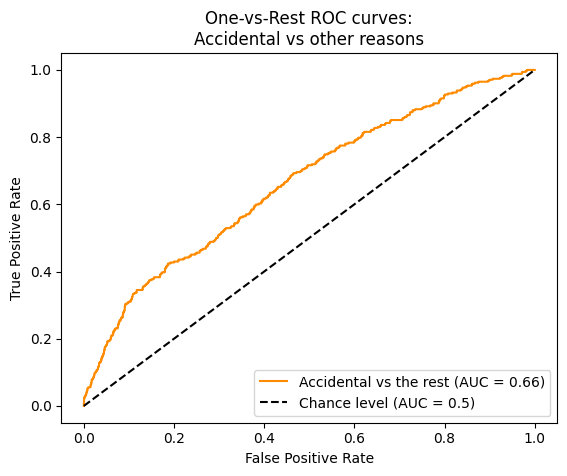

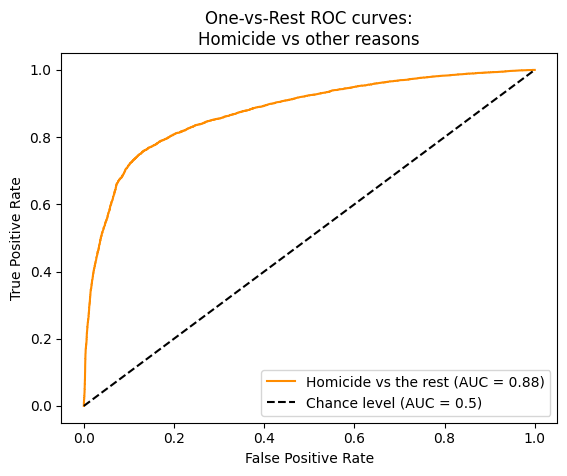

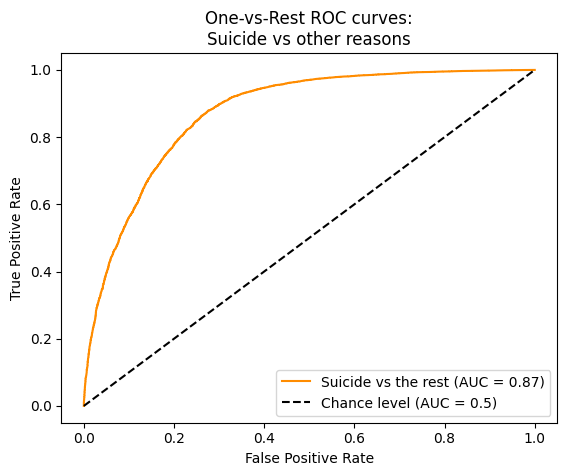

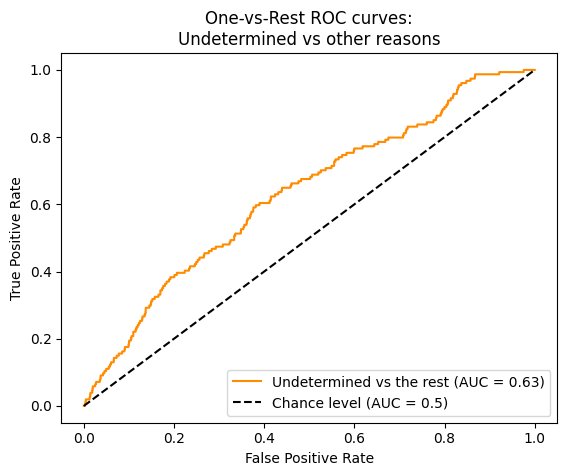

In [79]:
y_pred = best_model_imp.predict(x_test_imp)
y_score = best_model_imp.predict_proba(x_test_imp)  # Predicted probabilities for each class

# Compute accuracy and classification report
accuracy = accuracy_score(y_test_imp, y_pred)
report = classification_report(y_test_imp, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

# Binarize the labels for ROC curve calculation
label_binarizer = LabelBinarizer().fit(y_train_imp)
y_onehot_test = label_binarizer.transform(y_test_imp)

# Plot ROC curves for each class (One-vs-Rest)
for reason in label_binarizer.classes_:
    class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],  # True labels for that class
        y_score[:, class_id],        # Predicted probabilities for that class
        name=f"{reason} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )

    # Set ROC curve labels and title
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
    )

In [80]:
#coefficients: x_train_imp.columns
acc_model_imp = best_model_imp.coef_[[0]]
hom_model_imp = best_model_imp.coef_[[1]]
suicide_model_imp = best_model_imp.coef_[[2]]
undet_model_imp = best_model_imp.coef_[[3]]

### Logistic Regression on Removed Data ##

In [74]:
warnings.filterwarnings('ignore')
best_model_rem = train_evaluate_lr(x_train_rem,y_train_rem,x_test_rem,y_test_rem)
best_model_rem

Best parameters: {'multi_class': 'ovr', 'penalty': 'none'}
Best cross-validated score: 0.41975686491696185
Test set score: 0.6541660288790244


LogisticRegression(multi_class='ovr', penalty='none', random_state=42)

Accuracy: 0.6541660288790244
Classification Report:
              precision    recall  f1-score   support

  Accidental       0.04      0.31      0.08       331
    Homicide       0.76      0.75      0.76      6692
     Suicide       0.90      0.62      0.73     12425
Undetermined       0.01      0.21      0.03       151

    accuracy                           0.65     19599
   macro avg       0.43      0.47      0.40     19599
weighted avg       0.83      0.65      0.72     19599



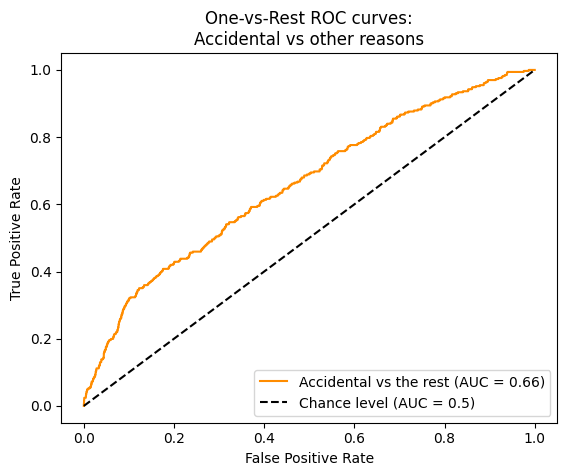

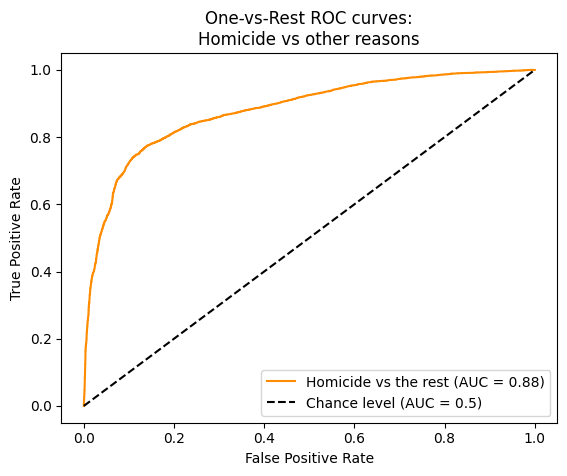

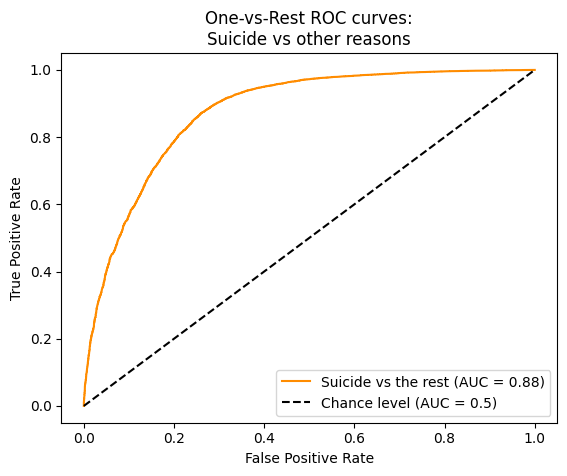

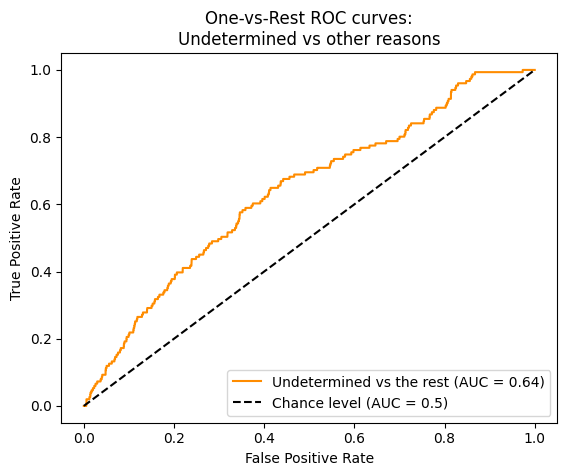

In [75]:
y_pred = best_model_rem.predict(x_test_rem)
y_score = best_model_rem.predict_proba(x_test_rem)  # Predicted probabilities for each class

# Compute accuracy and classification report
accuracy = accuracy_score(y_test_rem, y_pred)
report = classification_report(y_test_rem, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

# Binarize the labels for ROC curve calculation
label_binarizer = LabelBinarizer().fit(y_train_rem)
y_onehot_test = label_binarizer.transform(y_test_rem)

# Plot ROC curves for each class (One-vs-Rest)
for reason in label_binarizer.classes_:
    class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],  # True labels for that class
        y_score[:, class_id],        # Predicted probabilities for that class
        name=f"{reason} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )

    # Set ROC curve labels and title
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
    )

In [76]:
#coefficients: x_train_rem.columns
acc_model_rem = best_model_rem.coef_[[0]]
hom_model_rem = best_model_rem.coef_[[1]]
suicide_model_rem = best_model_rem.coef_[[2]]
undet_model_rem = best_model_rem.coef_[[3]]

# Baseline Decision Tree

In [ ]:
warnings.filterwarnings('ignore')
# Define a function to train and evaluate a baseline decision tree model with ROC curves
def train_evaluate_decision_tree(X_train, y_train, X_test, y_test):
    # Initialize Decision Tree Classifier with default parameters
    clf = DecisionTreeClassifier(random_state=42)
    
    # Define the hyperparameter grid
    param_grid = {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

    # Set up GridSearchCV with F1 scoring
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    # Get the best estimator from GridSearchCV
    best_clf = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    for reason in label_binarizer.classes_:
        class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{reason} vs the rest",
            color="darkorange",
            plot_chance_level=True)
        
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
            )
    

    print("Best Hyperparameters:", grid_search.best_params_)
    return accuracy, report



# Train and evaluate the model on both datasets
print("Evaluating Decision Tree on Dataset with Removed Missing Values:")
accuracy_remove, report_remove = train_evaluate_decision_tree(x_train_rem, y_train_rem, x_test_rem, y_test_rem)
print(f"Accuracy: {accuracy_remove}")
print("Classification Report:\n", report_remove)


Evaluating Decision Tree on Dataset with Removed Missing Values:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.7087606510536252
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.04      0.08      0.05       331
    Homicide       0.65      0.66      0.66      6692
     Suicide       0.81      0.76      0.78     12425
Undetermined       0.00      0.01      0.01       151

    accuracy                           0.71     19599
   macro avg       0.38      0.38      0.37     19599
weighted avg       0.74      0.71      0.72     19599



In [86]:
print("\nEvaluating Decision Tree on Dataset with Imputed Missing Values:")
accuracy_impute, report_impute = train_evaluate_decision_tree(x_train_imp, y_train_imp, x_test_rem, y_test_rem)
print(f"Accuracy: {accuracy_impute}")
print("Classification Report:\n", report_impute)


Evaluating Decision Tree on Dataset with Imputed Missing Values:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.7108015715087505
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.04      0.08      0.05       331
    Homicide       0.66      0.66      0.66      6692
     Suicide       0.81      0.76      0.78     12425
Undetermined       0.00      0.01      0.00       151

    accuracy                           0.71     19599
   macro avg       0.38      0.38      0.37     19599
weighted avg       0.74      0.71      0.72     19599



## Random Forest

### Random forest classifier on resampled data (removed)

In [88]:
reason_classes = list(y_train_rem.unique())

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}

def train_evaluate_rf(x_train, y_train, x_test, y_test, penalise):
    if penalise == True:
        rfc = RandomForestClassifier(random_state=42, class_weight="balanced")
        CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3, error_score='raise', scoring='f1_weighted')
    else:
        rfc = RandomForestClassifier(random_state=42)
        CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3, error_score='raise', scoring='f1_macro')
    CV_rfc.fit(x_train, y_train)
    best_param = CV_rfc.best_params_
    y_pred = CV_rfc.predict(x_test)
    y_score = CV_rfc.fit(x_train, y_train).predict_proba(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    for reason in reason_classes:
        class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{reason} vs the rest",
            color="darkorange",
            plot_chance_level=True,)
        
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
            )
    return best_param, accuracy, report


Evaluating Random Forest Classifier on Dataset with Removed Missing Values:
Accuracy: 0.6727894280320424
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.06      0.29      0.09       331
    Homicide       0.78      0.73      0.76      6692
     Suicide       0.88      0.66      0.75     12425
Undetermined       0.01      0.23      0.03       151

    accuracy                           0.67     19599
   macro avg       0.43      0.48      0.41     19599
weighted avg       0.83      0.67      0.74     19599



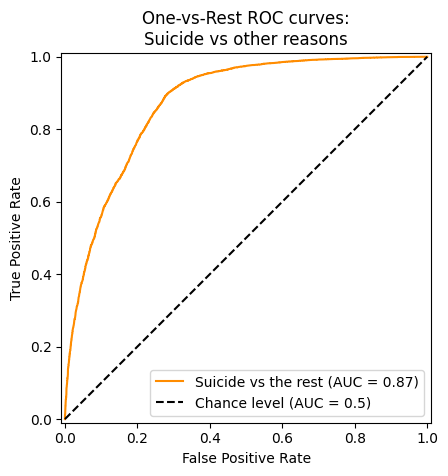

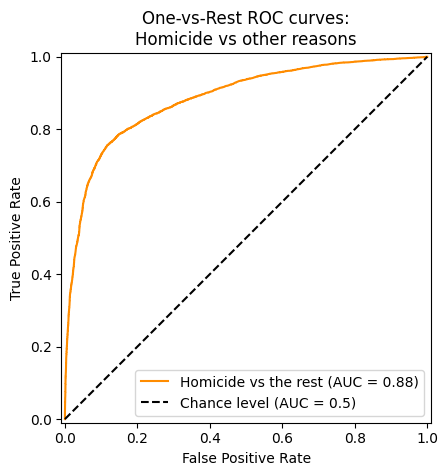

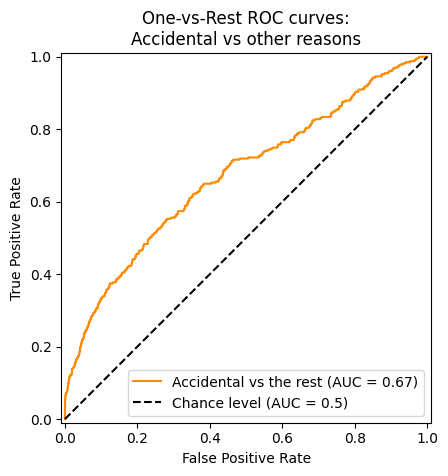

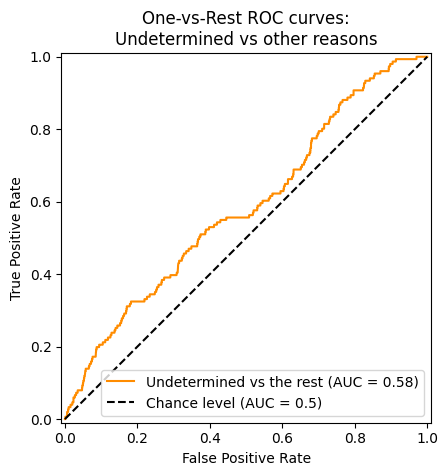

In [ ]:
best_param_rem_resample, accuracy_rem_resample, report_rem_resample = train_evaluate_rf(x_train_rem, y_train_rem, x_test_rem, y_test_rem, False)

print("\nEvaluating Random Forest Classifier on Dataset with Removed Missing Values:")
print(f"Accuracy: {accuracy_rem_resample}")
print("Classification Report:\n", report_rem_resample)

### Random forest classifier on resampled data


Evaluating Random Forest Classifier on Dataset with Imputed Missing Values:
Accuracy: 0.6722791979182612
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.06      0.28      0.10       331
    Homicide       0.78      0.73      0.76      6692
     Suicide       0.88      0.66      0.75     12425
Undetermined       0.01      0.25      0.03       151

    accuracy                           0.67     19599
   macro avg       0.43      0.48      0.41     19599
weighted avg       0.83      0.67      0.74     19599



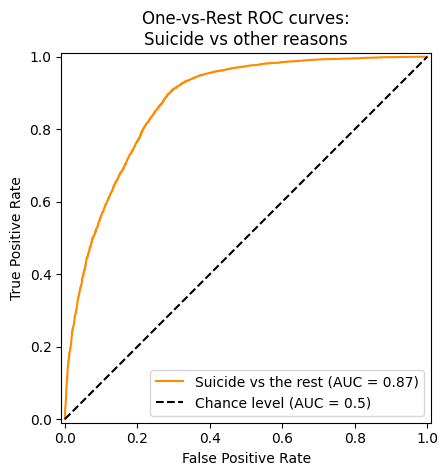

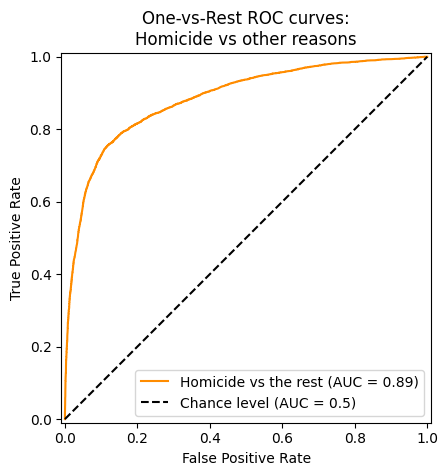

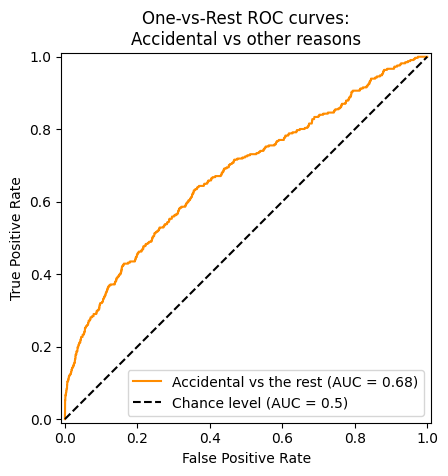

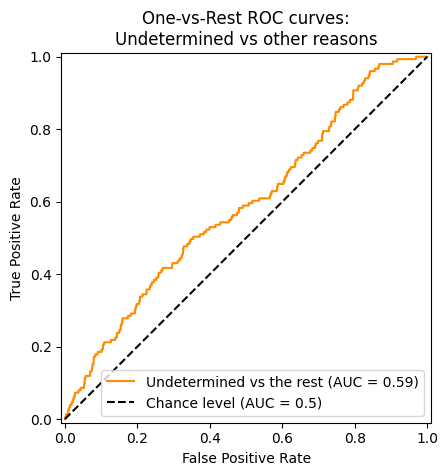

In [ ]:
best_param_imp_resample, accuracy_imp_resample, report_imp_resample = train_evaluate_rf(x_train_imp, y_train_imp, x_test_rem, y_test_rem, False)

print("\nEvaluating Random Forest Classifier on Dataset with Imputed Missing Values:")
print(f"Accuracy: {accuracy_imp_resample}")
print("Classification Report:\n", report_imp_resample)

### Random Forest with class weights on original imputed data


Evaluating Random Forest Classifier with class weights on Dataset with Imputed Missing Values:
Accuracy: 0.7245267615694678
Classification Report:
               precision    recall  f1-score   support

  Accidental       0.06      0.24      0.10       331
    Homicide       0.75      0.76      0.75      6692
     Suicide       0.88      0.73      0.79     12425
Undetermined       0.02      0.13      0.03       151

    accuracy                           0.72     19599
   macro avg       0.43      0.46      0.42     19599
weighted avg       0.81      0.72      0.76     19599



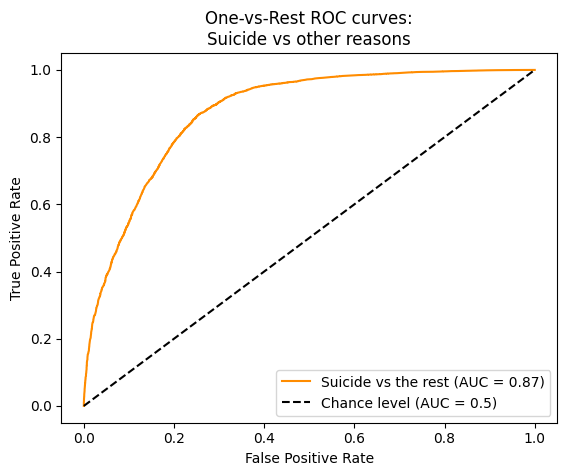

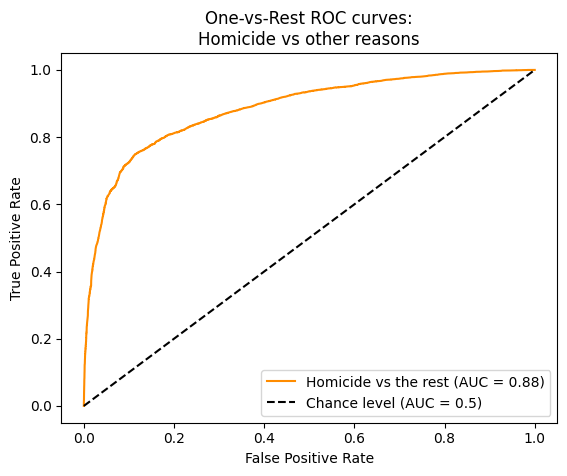

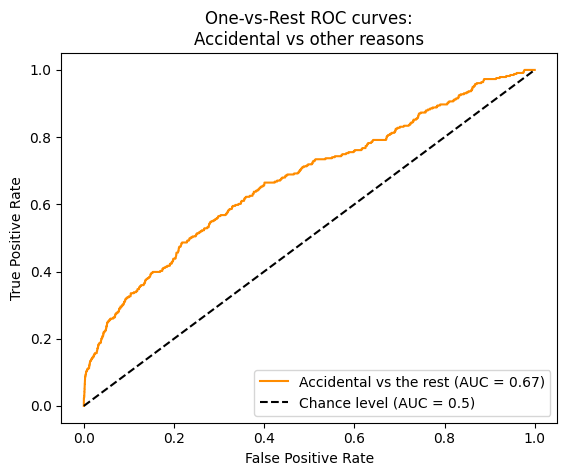

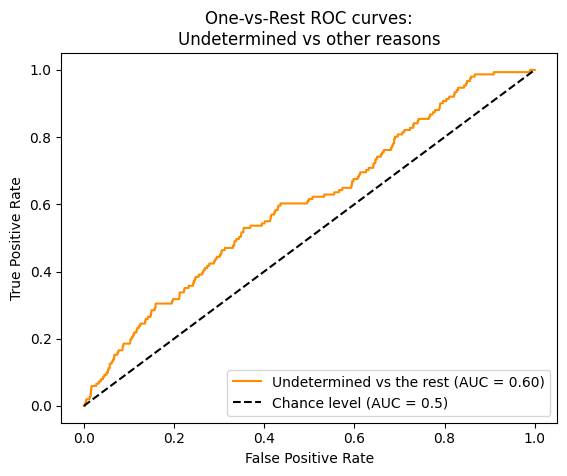

In [89]:
best_param_imb, accuracy_imb, report_imb = train_evaluate_rf(x_train_imb, y_train_imb, x_test_rem, y_test_rem, True)

print("\nEvaluating Random Forest Classifier with class weights on Dataset with Imputed Missing Values:")
print(f"Accuracy: {accuracy_imb}")
print("Classification Report:\n", report_imb)

## XGBoost

In [ ]:
#replacing our labels with [0 1 2 3] for XGBoost because it literally refuses to take the categorical labels
labels_numeric = {"Accidental": 0, "Homicide": 1,"Suicide":2,"Undetermined":3}

y_train_rem_num = y_train_rem.replace(labels_numeric)
y_test_rem_num = y_test_rem.replace(labels_numeric)

y_train_imp_num = y_train_imp.replace(labels_numeric)
y_test_imp_num = y_test_imp.replace(labels_numeric)


In [ ]:
# Define a function to train and evaluate a XGBoost model

xgb_reason_classes = list(y_train_rem_num.unique())
param_grid_xgb = {
    'max_depth': [15, 18, 20],
    'learning_rate': [0.1, 0.3, 0.6],
    'subsample': [0.5, 0.7, 1]
}
def train_evaluate_xgboost(X_train, y_train, X_test, y_test):
    # Initialize XGBoost Classifier with default parameters
    xgbc = xgb.XGBClassifier()
    
    # Train the model
    #xgbc.fit(X_train, y_train)
    
    # Make predictions
    CV_xgbc = GridSearchCV(xgbc, param_grid_xgb, cv= 5, scoring='f1', n_jobs=-1)
    CV_xgbc.fit(X_train, y_train)
    best_param = CV_xgbc.best_params_
    y_pred = CV_xgbc.predict(X_test)
    y_score = CV_xgbc.fit(X_train, y_train).predict_proba(X_test)
    
    #y_pred = xgbc.predict(X_test)
    #y_score = xgbc.fit(X_train, y_train).predict_proba(X_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    for reason in xgb_reason_classes:
        class_id = np.flatnonzero(label_binarizer.classes_ == reason)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{reason} vs the rest",
            color="darkorange",
            plot_chance_level=True)
        
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"One-vs-Rest ROC curves:\n{reason} vs other reasons",
            )
    

    return best_param, accuracy, report

### XGBoost classifier on resampled data (removed)

In [ ]:
print("Evaluating XGBoost on Dataset with Removed Missing Values:")
xgb_best_param_remove, xgb_accuracy_remove, xgb_report_remove = train_evaluate_xgboost(x_train_rem, y_train_rem_num, x_test_rem, y_test_rem_num)
print(f"Accuracy: {xgb_accuracy_remove}")
print("Classification Report:\n", xgb_report_remove)
print("Best Parameters:", xgb_best_param_remove)

### XGBoost classifier on resampled data (imputed)

In [ ]:
print("Evaluating XGBoost on Dataset with Imputed Missing Values:")
xgb_best_param_impute, xgb_accuracy_impute, xgb_report_impute = train_evaluate_xgboost(x_train_imp, y_train_imp_num, x_test_imp, y_test_rem_num)
print(f"Accuracy: {xgb_accuracy_remove}")
print("Classification Report:\n", xgb_report_remove)
print("Best Parameters:", xgb_best_param_impute)